## 1D Heat Equation with FVM

In [1]:
using LinearAlgebra, LinearSolve, Plots, LaTeXStrings

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Module SciMLBase with build ID ffffffff-ffff-ffff-0004-21d2506e618a is missing from the cache.
│ This may mean SciMLBase [0bca4576-84f4-4d90-8ffe-ffa030f20462] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module LinearSolve with build ID ffffffff-ffff-ffff-0004-21cf5dd95719 is missing from the cache.
│ This may mean LinearSolve [7ed4a6bd-45f5-4d41-b270-4a48e9bafcae] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541


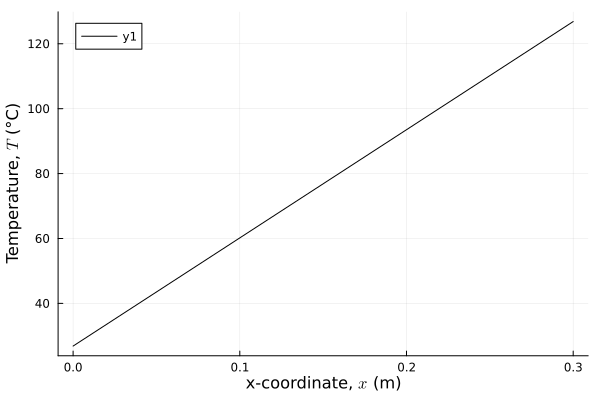

In [2]:
# Problem specs
T_loBC = 300.
T_upBC = 400.
k = 50.
L = 0.3

# Discretization
Nx = 100
dx = L/(Nx+1)
x_vec = range(0, L, Nx+2)

# Setting coefficients
aE = fill(k / dx, Nx)
aW = fill(k / dx, Nx)
aP = aE + aW
A = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
b = zeros(Nx)
b[1] = (k/dx) * T_loBC
b[end] = (k/dx) * T_upBC

# Solving (LSEs)
prob = LinearProblem(A, b)
sol = solve(prob)

# Plotting
Tx_vec = sol.u
append!(sol.u, T_upBC)
insert!(Tx_vec, 1, T_loBC)
plot(x_vec, Tx_vec.-273.15, xlabel=L"x-coordinate, $x$ (m)", ylabel=L"Temperature, $T$ (°C)", c="black")

In [3]:
# Problem specs
S(T) = - T^2
dT = 0.001

# Iterative solution

## Initializing
i=0
imax = 100
atol = 1e-6
T0 = ones(Nx) * ((T_loBC+T_upBC) / 2.0);      # Initial guess

while i<imax

    ## Setting coefficients
    dSdT = @. (S(T0+dT) - S(T0)) / dT 
    S_P = dSdT
    S_C = @. S(T0) - dSdT*T0
    aE = fill(k / dx, Nx)
    aW = fill(k / dx, Nx)
    aP = aE + aW - S_P*dx
    A = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
    b = S_C*dx
    b[1] = (k/dx) * T_loBC
    b[end] = (k/dx) * T_upBC
    
    ## Solving (LSEs)
    prob = LinearProblem(A, b)
    sol = solve(prob)

    ## Checking convergence criteria
    if norm(sol.u-T0, 2) < atol
        println(i)
        println("Converged!")
        break
    end

    ## Updating loop variables
    T0 = copy(sol.u)
    i += 1
end

3
Converged!


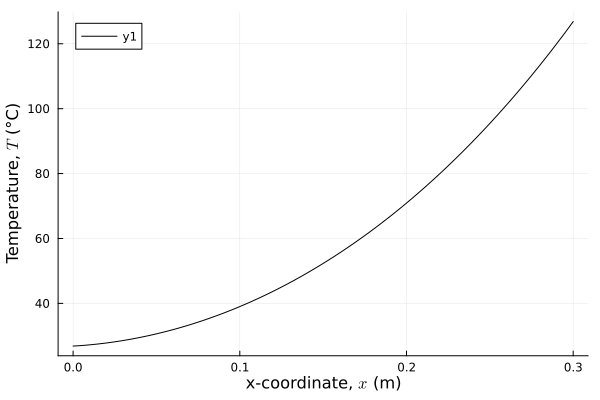

In [4]:
# Plotting
Tx_vec = sol.u
append!(sol.u, T_upBC)
insert!(Tx_vec, 1, T_loBC)
plot(x_vec, Tx_vec.-273.15, xlabel=L"x-coordinate, $x$ (m)", ylabel=L"Temperature, $T$ (°C)", c="black")

In [6]:
# Problem specs
rho = 2000
cp = 420
alpha = k / (rho * cp)       
T_loBC = 0.
T_upBC = 0.

# Initial condition
T0x_vec = @. 300 * sin((2*pi / L) * x_vec);

In [7]:
# Numeric solution

dt = (dx^2 / (2.0*alpha))
t = 0.
tf = L^2/alpha / 12
t_vec = range(0, tf, 6)
T = T0x_vec[2:end-1]

Txt_mat = zeros((Nx+2, length(t_vec)))
Txt_mat[2:end-1,1] = copy(T)
i = 2

while t<tf

    ## Setting coefficients
    T_P0 = T
    S_P = 0.; S_C = 0.
    aE = fill(k / dx, Nx)
    aW = fill(k / dx, Nx)
    aP0 = (rho * cp * dx) / dt
    aP = @. aE + aW + aP0 - S_P*dx
    A = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
    b = @. S_C*dx + aP0*T_P0
    b[1] = b[1] .+ (k/dx) * T_loBC
    b[end] = b[end] .+ (k/dx) * T_upBC

    ## Solving (LSEs)
    prob = LinearProblem(A, b)
    sol = solve(prob)
    T = sol.u

    # ## Saving solution
    if t > t_vec[i]
        Txt_mat[2:end-1, i] = copy(T)
        i += 1
    end

    t += dt

end

Txt_mat[2:end-1, end] = copy(T);

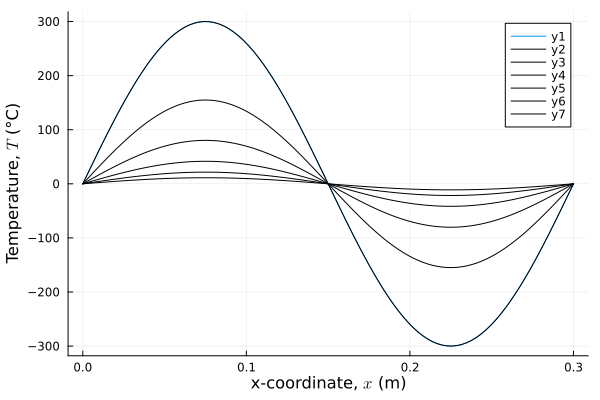

In [8]:
# Plotting

plt = plot(x_vec, T0x_vec)
for (i_t,t) in enumerate(t_vec)
    Tx_vec = sol.u
    plot!(plt, x_vec, Txt_mat[1:end, i_t], xlabel=L"x-coordinate, $x$ (m)", ylabel=L"Temperature, $T$ (°C)", c="black")
end
plt

In [82]:
# Numeric solution

function solve_ODE(Txt_mat, T0, t_vec, pars, memory)

    t = t_vec[1]; tf = t_vec[end]
    T = T0

    k, dt, dx, rho, cp = pars
    aE, aW, aP0, aP, A, b = memory
    Txt_mat[2:end-1,1] = copy(T)
    i = 2

    while t<tf

        ## Setting coefficients
        T0 = T
        S_P = 0.; S_C = 0.
        aE[:] .= k / dx
        aW[:] .= k / dx
        aP0[:] .= (rho * cp * dx) / dt
        aP[:] = @. aE + aW + aP0 - S_P*dx
        A[:] = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
        b[:] = @. S_C*dx + aP0*T0
        b[1] = b[1] .+ (k/dx) * T_loBC
        b[end] = b[end] .+ (k/dx) * T_upBC

        ## Solving (LSEs)
        prob = LinearProblem(A, b)
        sol = solve(prob)
        T = sol.u

        ## Saving solution
        if t > t_vec[i]
            Txt_mat[2:end-1, i] = copy(T)
            i += 1
        end

        t += dt

    end

    Txt_mat[2:end-1, end] = copy(T)
end

solve_ODE (generic function with 1 method)

In [83]:
dt = (dx^2 / (2.0*alpha))
t = 0.
tf = L^2/alpha / 12
t_vec = range(0, tf, 6)

T0 = T0x_vec[2:end-1]
Txt_mat = zeros((Nx+2, length(t_vec)))
aE = zeros(Nx); aW = zeros(Nx); aP0 = zeros(Nx); aP = zeros(Nx)
A = zeros((Nx, Nx)); b = zeros(Nx)
memory = (aE, aW, aP0, aP, A, b)
pars = (k, dt, dx, rho, cp)

(50.0, 0.07411038133516322, 0.0029702970297029703, 2000, 420)

In [85]:
sol = solve_ODE(Txt_mat, T0, t_vec, pars, memory);